In [1]:
import numpy as np
import torch

#### data names

In [2]:
# from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,    #True if not dowloaded
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,    #True if not dowloaded
    transform=ToTensor()
)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Define NN part

In [4]:
# import os
from torch import nn
# from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):
    def __init__(self):
        # call __init__ from the parent class: nn.Module.
        super(NeuralNetwork, self).__init__()
        
        # this flattens the images in the batch to the 1d tensors suitabe for nn.Sequential
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 16),  #  input -> 1st layer  = first hidden layer  16 neurons. (like matrix of shape: 16 x 784)
            nn.ReLU(),             # ReLU activation funtion at 16 neurons of the 1st layer
            nn.Linear(16, 16),     # 1st layer -> 2nd layer = second hidden layer with 16 neurons
            nn.ReLU(),             # ReLU activation funtion at 16 neurons of the 2nd layer
            nn.Linear(16, 10),     # 2nd layer -> output 
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for i, batch in enumerate(dataloader):
        # Compute prediction and loss
        X, y = batch[0].to(device), batch[1].to(device)
        pred = model(X)            #*mat: evaluate the model batch_size of times and put results in a tensor "next" to each other
        loss = loss_fn(pred, y)    #*mat: compute the loss function 

        # Backpropagation
        optimizer.zero_grad()      # place in memory for the derivative needs reseting
        loss.backward()            #*mat: calculate the derivative (**)
        optimizer.step()           # call the black box algoritm that do the magic

        # print the progress every 100th batch.
        if i % 100 == 0:
            loss, current = loss.item(), i * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[0].to(device), batch[1].to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### train-y part

In [103]:
# hyperparameters
learning_rate = 1e-2
batch_size = 100
epochs = 5

loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork().to(device) 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


In [104]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=100, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=True, pin_memory=True)

In [105]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.334503  [    0/60000]
loss: 1.439916  [10000/60000]
loss: 0.548414  [20000/60000]
loss: 0.410761  [30000/60000]
loss: 0.493014  [40000/60000]
loss: 0.328411  [50000/60000]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.331461 

Epoch 2
-------------------------------
loss: 0.287031  [    0/60000]
loss: 0.325892  [10000/60000]
loss: 0.206460  [20000/60000]
loss: 0.506496  [30000/60000]
loss: 0.300466  [40000/60000]
loss: 0.281228  [50000/60000]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.278768 

Epoch 3
-------------------------------
loss: 0.249926  [    0/60000]
loss: 0.329086  [10000/60000]
loss: 0.113245  [20000/60000]
loss: 0.296915  [30000/60000]
loss: 0.298392  [40000/60000]
loss: 0.205776  [50000/60000]
Test Error: 
 Accuracy: 92.9%, Avg loss: 0.248103 

Epoch 4
-------------------------------
loss: 0.164818  [    0/60000]
loss: 0.275655  [10000/60000]
loss: 0.424604  [20000/60000]
loss: 0.186129  [30000/60000]
loss: 0.234268  [40000/6

In [106]:
# result for random image
X = torch.rand(1, 28, 28, device=device) # random image
print(model(X))

tensor([[  2.3483,  -3.7659,   2.1727,   5.7998, -10.4997,   2.7526,  -3.3734,
         -10.7476,   6.2890,  -4.6178]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


tensor([[-1.5025, -1.7869, -1.8945,  0.0168, -6.9241,  2.1257, -2.2416, -7.7897,
         12.7867,  0.1850]], device='cuda:0', grad_fn=<AddmmBackward0>)
8


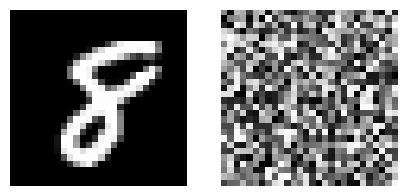

In [122]:
import matplotlib.pyplot as plt
ith = 777
img, label = training_data[ith]
print(model(img.to(device)))
print(label)
fig = plt.figure(figsize=(5, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap="gray")
plt.axis("off")
fig.add_subplot(1, 2, 2)
plt.imshow(X.to('cpu').squeeze(), cmap="gray")
plt.axis("off")
plt.show()

In [108]:
# random pic X
for i,x in enumerate(model(X)[0]):
    print(f" At {i:<4} NN has {x.item():>8.2f}")

 At 0    NN has     2.35
 At 1    NN has    -3.77
 At 2    NN has     2.17
 At 3    NN has     5.80
 At 4    NN has   -10.50
 At 5    NN has     2.75
 At 6    NN has    -3.37
 At 7    NN has   -10.75
 At 8    NN has     6.29
 At 9    NN has    -4.62


In [109]:
img777, label = training_data[777]
for i,x in enumerate(model(img777.to(device))[0]):
    print(f" At {i:<4} NN has {x.item():>8.2f}")

 At 0    NN has    -1.50
 At 1    NN has    -1.79
 At 2    NN has    -1.89
 At 3    NN has     0.02
 At 4    NN has    -6.92
 At 5    NN has     2.13
 At 6    NN has    -2.24
 At 7    NN has    -7.79
 At 8    NN has    12.79
 At 9    NN has     0.18
